<a href="https://colab.research.google.com/github/CompPsychology/psych290_colab_public/blob/main/notebooks/week-05/W5_Tutorial_08_R_featTable_statsAndPlots_preHW5_(dla_tutorial).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W5 Tutorial 8 -- R feat table stats and plots (DB: dla_tutorial) (2025-3)

(c) Johannes Eichstaedt & the World Well-Being Project, 2023.

✋🏻✋🏻 NOTE - You need to create a copy of this notebook before you work through it. Click on "Save a copy in Drive" option in the File menu, and safe it to your Google Drive.

✉️🐞 If you find a bug/something doesn't work, please slack us a screenshot, or email johannes.courses@gmail.com.

## 1) Setting up Colab with DLATK, SQLite, and R

In [ ]:
database = "dla_tutorial"

### 1a) Install DLATK

In [ ]:
# installing DLATK and necessary packages
!git clone -b psych290 https://github.com/dlatk/dlatk.git
!pip install -r dlatk/install/requirements.txt
!pip install dlatk/
!pip install wordcloud langid jupysql

### 1b) Download custom R script

In [ ]:
# this download the R script we need
!git clone https://github.com/CompPsychology/psych290_data.git

Cloning into 'psych290_data'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 30 (delta 3), reused 10 (delta 2), pack-reused 17 (from 1)
Receiving objects: 100% (30/30), 28.70 MiB | 19.63 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Look on the left in the file browser, you see `psych290RcodeV1.R` located in ./psych290_data/helper_files (as well as csv files in for `tutorial_07` and `dla_tutorial`!)

💡 BTW, if you ever need a copy of `psych290RcodeV1.R` (RStudio at home!), [you can download it here!](https://drive.google.com/drive/folders/1LnEKn7tyBiXLsuNl_SXkqljZFRUs9S4k?usp=sharing)

### 1c) Mount Google Drive and copy databases & custom R functions

In case you don't have that `dlatk_lexica.db` in your Google Drive, look at Tutorial 5.

In [ ]:
# Mount Google Drive & copy to Colab

# connects & mounts your Google Drive to this colab space
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# this copies dlatk_lexica.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/dlatk_lexica.db" "sqlite_data"

# this copies {database}.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/{database}.db" "sqlite_data"

Mounted at /content/drive


### 1d) Setup database connection

In [ ]:
# loads the %%sql extension
%load_ext sql

# connects the extension to the database - mounts both databases as engines
from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# attaches the dlatk_lexica.db so tutorial_db_engine can query both databases
from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

#set the output limit to 50
%config SqlMagic.displaylimit = 50

### 1e) (ONLY If nedded: SOFT RELOAD) If you have a **"database lock"** problem

In [ ]:
# If you face a "database locked" issue, restart the session (Runtime ==> Restart Session) & run this cell to get set back up!

database = "dla_tutorial"

%reload_ext sql

from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# set the output limit to 50
%config SqlMagic.displaylimit = 50

from IPython import get_ipython
from sqlalchemy import event

# auto‑attach the lexica db whenever tutorial_db_engine connects
@event.listens_for(tutorial_db_engine, "connect")
def _attach_lexica(dbapi_conn, connection_record):
    dbapi_conn.execute("ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

%sql tutorial_db_engine

## 2) Setup R

Load the R extension.

In [ ]:
# load %%R extension
%load_ext rpy2.ipython

Download and load necessary packages!

In [ ]:
# this is equivalent to install.packages() but much faster!!
!apt-get update -qq

!apt-get install -y \
  r-cran-ggthemes \
  r-cran-reshape2 \
  r-cran-psych \
  r-cran-apatables \
  r-cran-rsqlite \
  r-cran-ggrepel

In [ ]:
%%R

# custom R script functions for dlatk
source("./psych290_data/helper_files/psych290RcodeV1.R")

# loads necessary libraries
require(tidyverse)
require(ggthemes)
require(grid)
require(reshape2)
require(psych)


Let's connect to our SQLite database using RSQLite.  Remember to assign the `database` variable with your database name!

In [ ]:
# constructs the file path based on your database name
database_path = f"sqlite_data/{database}.db"

In [ ]:
%%R -i database_path

# load DBI for generic database functions and RSQLite as the SQLite backend
library(DBI)
library(RSQLite)

# connects to a file-based sqlite DB
db_con <- dbConnect(RSQLite::SQLite(),
                    dbname = database_path)

# enforce UTF-8 encoding
dbExecute(db_con, "PRAGMA encoding = 'UTF-8';")

# this attaches the dlatk_lexica database
dbExecute(db_con, "ATTACH DATABASE 'sqlite_data/dlatk_lexica.db' AS dlatk_lexica;")

[1] 0


```
🐬🐬🐬
db_con = dbConnect(MySQL(), user=SUNET, password="", dbname=database, host='localhost', encoding='UTF-8')

dbSendQuery(db_con, "SET NAMES utf8mb4;")
dbSendQuery(db_con, "SET CHARACTER SET utf8mb4;")
dbSendQuery(db_con, "SET character_set_connection=utf8mb4;")
🐬🐬🐬
```

Use `dbGetQuery()` from RSQLite with the database connection to fire off SQL commands and get their output! The function has the form `dbGetQuery(db_con, <query>)`, where `<query>` can be any query from your tutorials/homeworks until now.

Lets use it to see what tables we have in our database!

Notice how `dla_tutorial` and `dlatk_lexica` tables are included there too, but part of a different attached database (indicated by the `schema` columns).

In [ ]:
%R dbGetQuery(db_con, "PRAGMA table_list")

To see all these tables in MySQL:

```
🐬🐬🐬
dbGetQuery(db_con, "SHOW DATABASES")

dbGetQuery(db_con, "USE dla_tutorial")
dbGetQuery(db_con, "SHOW TABLES")

dbGetQuery(db_con, "USE dlatk_lexica")
dbGetQuery(db_con, "SHOW TABLES")
🐬🐬🐬
```


### 2a) Read from database into a dataframe

As expected `dbGetQuery()` returns the output of SELECT as well. Here we store it in the dataframe 'df'.

In [ ]:
%%R

df <- dbGetQuery(db_con, "SELECT * FROM msgs LIMIT 3")

You can explore df below.

Remember the line magic `%R` sends the df back to python to be displayed nicely, but you could also do `%%R df` 🙂

In [ ]:
%R df

,message_id,user_id,date,created_time,message
1,1,3991108,"31,July,2004",2004-07-31 00:00:00,can you believe it?? my mom wouln't let me ...
2,2,3991108,"25,July,2004",2004-07-25 00:00:00,miss su used to be my living skills teache...
3,3,3991108,"24,July,2004",2004-07-24 00:00:00,i'm lookin for info about cancer in bm...i ...


## 3) Intro to feature tables in R

This section is about revisiting some of our queries from previous homeworks which we had done with DLATK + SQL. Here we'll see (and get impressed) how easy it gets with the addition of R in our workflow.

First of all, let's read our user-level feature table and plot the distribution of tokens. Zipf's distibution in all its glory!!

Then we have to get the frequency of every token which can be done with a group by followed by a sum as below. Remember to order it in decreasing order of frequency.

`checkDf2()` will provide helpful quality control ...



In [ ]:
%%R

counts <- dbGetQuery(
  db_con,
  "SELECT feat, SUM(value) as freq FROM feat$1gram$msgs$user_id GROUP BY feat ORDER BY freq DESC")

In [ ]:
%%R

checkDf(counts)

  names na_count is_numericy
1  feat        0           0
2  freq        0           1


In [ ]:
%%R

checkDf2(counts)

  names NAs numeric min    max zeroes  nonNA unique
1  feat   0       0                                
2  freq   0       1   1 365156      0 137687   1459



...you can see that frequencies range from 1 to 365158.

Let's normalize the frequency (divide by the total count)



In [ ]:
%%R

counts$n_freq <- counts$freq / sum(counts$freq)


Now we can plot it using `ggplot2`.



In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


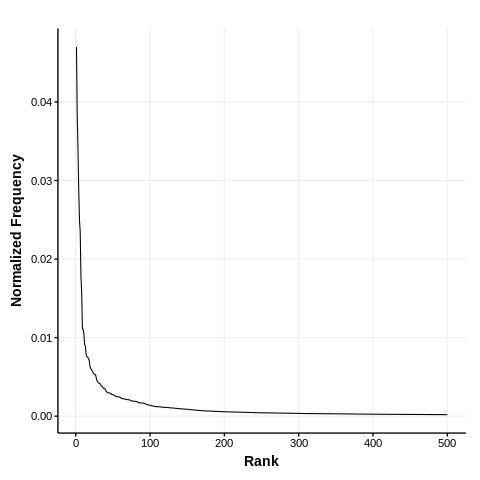

In [ ]:
%%R

until_which_word <- 500

ggplot(
  data=counts[1:until_which_word, ],
  aes(x=c(1:until_which_word), y=counts$n_freq[1:until_which_word])) +
  xlab('Rank') +
  ylab('Normalized Frequency') +
  geom_line() +
  theme_Publication()


That looks like a perfect 1/rank plot! let's look at the top 50 words by annotating the graph with it, using the awesome ggrepel package with gives us the `geom_text_repel` geom for ggplot.



Loading required package: ggrepel
In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


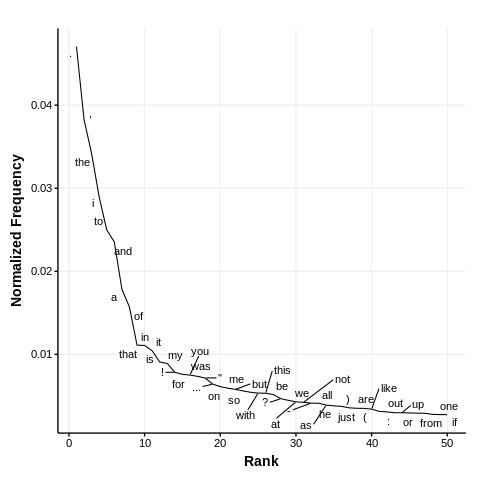

In [ ]:
%%R

require(ggrepel)

until_which_word <- 50

ggplot(
  data=counts[1:until_which_word, ],
  aes(x=c(1:until_which_word), y=counts$n_freq[1:until_which_word], label = feat)) +
  xlab('Rank') +
  ylab('Normalized Frequency') +
  geom_line() +
  theme_Publication() +
  geom_text_repel()

Very nice!


## EXERCISES

(note: these [and the videos below] are based on slightly older versions of the homeworks.)

If you would like to see johannes do these live, see here:
[HW2](https://www.youtube.com/watch?v=MUrgTXZRGrk&list=PLHUagVZ9xkcz6EwJCk7Wj4dveH6M3pUBD),
[HW3](https://www.youtube.com/watch?v=zrrY8LBDHME&list=PLHUagVZ9xkcz6EwJCk7Wj4dveH6M3pUBD)

### HW1 Questions

Let's revisit some of the HW1 questions and solve them using R. We'll also check for trade-offs when we solve a question with R v/s SQL. Each tool is good to do certain things over the other.

#### Question 1-3

1. Calculate the minmimum, maximum and average age for both genders
2. Calculate the average age for every occupation
3. What's the average age difference between Libras and Leos?

To solve all of the above questions, we need only the `outcomes` table. Let's read that, and describe the columns.



In [ ]:
%%R

outcomes <- dbGetQuery(db_con, "SELECT * FROM outcomes")
checkDf2(outcomes)

           names NAs numeric   min     max zeroes nonNA unique
1        user_id   0       1 28451 4325889      0  1000   1000
2         gender   0       1     0       1    502  1000      2
3            age   0       1    13      48      0  1000     26
4           occu   0       0                                  
5           sign   0       0                                  
6      is_indunk   0       1     0       1    642  1000      2
7     is_student   0       0                                  
8   is_education   0       0                                  
9  is_technology   0       0                                  
10     wordcount   0       1   419  365311      0  1000    917



Now we just have to use `dplyr` to solve the questions.



First gender.

In [ ]:
%%R

outcomes %>%
  group_by(gender) %>%
  summarise(min = min(age), max = max(age), avg = mean(age))

# A tibble: 2 × 4
  gender   min   max   avg
   <int> <int> <int> <dbl>
1      0    13    48  23.1
2      1    13    48  23.3


---

🤓🤓 Try piping to data.frame (i.e., `%>% data.frame()` at the end) to make the output easier to read!

---

In [ ]:
%%R

outcomes %>%
  group_by(gender) %>%
  summarise(min = min(age), max = max(age), avg = mean(age)) %>%
  data.frame() # add data.frame here!

  gender min max      avg
1      0  13  48 23.11952
2      1  13  48 23.33735


See, much cleaner!

Now occupations.

In [ ]:
%%R

outcomes %>%
  group_by(occu) %>%
  summarise(mean(age)) %>%
  data.frame() # convert to data.frame, much easier to read!

                      occu mean.age.
1               Accounting  24.50000
2              Advertising  25.50000
3              Agriculture  17.00000
4             Architecture  28.33333
5                     Arts  23.06250
6               Automotive  30.50000
7                  Banking  27.87500
8                  Biotech  24.50000
9         BusinessServices  29.50000
10               Chemicals  15.00000
11    Communications-Media  27.66667
12            Construction  32.33333
13              Consulting  30.85714
14               Education  27.48000
15             Engineering  23.66667
16                 Fashion  26.60000
17              Government  28.43750
18          HumanResources  34.83333
19                Internet  28.29167
20                     Law  29.55556
21 LawEnforcement-Security  21.00000
22           Manufacturing  30.33333
23               Marketing  28.60000
24                Military  23.60000
25       Museums-Libraries  21.50000
26              Non-Profit  28.21429
2

To find the average ages for `Libra` and `Leo` we first filter users with only these star signs and then group by - summarise.



In [ ]:
%%R

outcomes %>%
  filter(sign == 'Libra' | sign == 'Leo') %>%
  group_by(sign) %>%
  summarise(mean(age)) %>%
  data.frame()

   sign mean.age.
1   Leo  22.77215
2 Libra  24.21687


#### Question 4-5

4. How many blog posts do we have from authors from a given age? i.e., how many from age 17, 18, etc
5. How many blog posts from authors in an industry?

Let's NOT get the entire `msgs` table to R (lots of data for R!), instead we will do the count of blogs per user in SQL and the rest here.

In [ ]:
%%R

blog_counts <- dbGetQuery(db_con, "SELECT user_id, COUNT(*) AS n_msgs FROM msgs GROUP BY user_id")
checkDf2(blog_counts)

    names NAs numeric   min     max zeroes nonNA unique
1 user_id   0       1 28451 4325889      0  1000   1000
2  n_msgs   0       1     1    2068      0  1000    143


We'll now import `outcomes`.



In [ ]:
%%R

outcomes <- dbGetQuery(db_con, "SELECT * FROM outcomes")
describe(outcomes)

               vars    n       mean        sd  median    trimmed       mad
user_id           1 1000 3466878.55 821083.19 3667234 3634453.51 469820.37
gender            2 1000       0.50      0.50       0       0.50      0.00
age               3 1000      23.23      8.32      23      22.19      8.90
occu*             4 1000      23.05      8.67      19      23.61      8.90
sign*             5 1000       6.65      3.44       7       6.64      4.45
is_indunk         6 1000       0.36      0.48       0       0.32      0.00
is_student*       7 1000       1.99      0.85       2       1.99      1.48
is_education*     8 1000       1.00      0.00       1       1.00      0.00
is_technology*    9 1000       1.00      0.00       1       1.00      0.00
wordcount        10 1000    7764.05  20983.66    2498    3843.64   2556.74
                 min     max   range  skew kurtosis       se
user_id        28451 4325889 4297438 -1.98     3.73 25964.93
gender             0       1       1  0.01    -2.00  

 Then we merge blog_counts with `outcomes`.

In [ ]:
%%R

merged <- merge(blog_counts, outcomes, by = 'user_id')

Now take a peak at the first few rows (using the nice %R line-magic).

In [ ]:
%R head(merged)

,user_id,n_msgs,gender,age,occu,sign,is_indunk,is_student,is_education,is_technology,wordcount
1,28451,13,0,27,Internet,Aquarius,0,0,NA,NA,1049
2,174357,3,1,23,indUnk,Aquarius,1,NA,NA,NA,649
3,216833,222,0,24,Student,Scorpio,0,1,NA,NA,55959
4,317581,619,0,26,Technology,Scorpio,0,0,NA,NA,69703
5,446275,8,1,17,indUnk,Virgo,1,NA,NA,NA,2202
6,450169,14,0,17,indUnk,Sagittarius,1,NA,NA,NA,954


Now we can solve the questions using `dplyr` group by and summarize.



First, question 4 (age).

In [ ]:
%%R

merged %>%
  group_by(age) %>%
  summarise(n_msgs = sum(n_msgs)) %>% arrange(age) %>%
  data.frame()

   age n_msgs
1   13    783
2   14   1417
3   15   2093
4   16   2255
5   17   3588
6   23   2790
7   24   4356
8   25   3304
9   26   2699
10  27   2979
11  33    711
12  34   2301
13  35    461
14  36    572
15  37    229
16  38    129
17  39     28
18  40    166
19  41     62
20  42     97
21  43    225
22  44     38
23  45    166
24  46      8
25  47     49
26  48    168


And question 5 (industry)?

In [ ]:
%%R

merged %>%
  group_by(occu) %>%
  summarise(n_msgs = sum(n_msgs)) %>%
  arrange(desc(occu)) %>%
  data.frame()

                      occu n_msgs
1                   indUnk  11548
2           Transportation     83
3                  Tourism     39
4       Telecommunications    125
5               Technology   2203
6                  Student   6650
7        Sports-Recreation    256
8                  Science    627
9                 Religion    395
10              RealEstate     14
11              Publishing     63
12              Non-Profit    584
13       Museums-Libraries      8
14                Military     47
15               Marketing    187
16           Manufacturing    136
17 LawEnforcement-Security     91
18                     Law    406
19                Internet   1599
20          HumanResources    159
21              Government    661
22                 Fashion     24
23             Engineering    202
24               Education   1717
25              Consulting    179
26            Construction     35
27    Communications-Media   1625
28               Chemicals    234
29        Busi

#### Question 6-7

6. How many blog posts do we have from a given year?
7. How many blog posts do we have from a given year ONLY WRITTEN BY TAURUSES?

Since these questions involve counting the rows from the `msgs` table, we better do these in SQL than importing the `msgs` table here. For Question 7, we do the join in SQL onto the outcomes table, that's more efficient.

### HW2 Questions


#### 1) How often was the word "the" mentioned, both in absolute numbers and as a average relative frequency?

Total counts:

Let's pick only feat table rows containing "the" as their feature.




In [ ]:
%%R

feat_the <- dbGetQuery(db_con, "SELECT * FROM `feat$1gram$msgs$user_id` WHERE feat = 'the'")

Sanity-check:

In [ ]:
%R head(feat_the)

,id,group_id,feat,value,group_norm
1,20,28451,the,28,0.026692
2,478,174357,the,6,0.009245
3,699,216833,the,2005,0.035830
4,6374,317581,the,1692,0.024274
5,12122,446275,the,85,0.038601
6,13019,450169,the,27,0.028302


Looks good.

Let's plot the number of users using "the".

In addition: Warning messages:
1: `qplot()` was deprecated in ggplot2 3.4.0.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: `legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


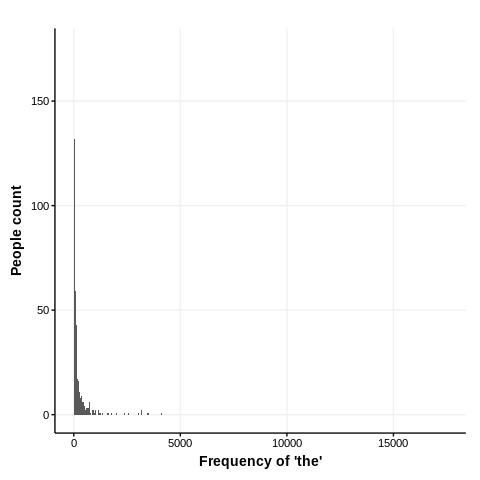

In [ ]:
%%R

qplot(feat_the$value, bins = 1000) +
  theme_Publication() +
  xlab("Frequency of 'the'") +
  ylab("People count")

`qplot()` is simply a shorter version of what `ggplot()` does below.

In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


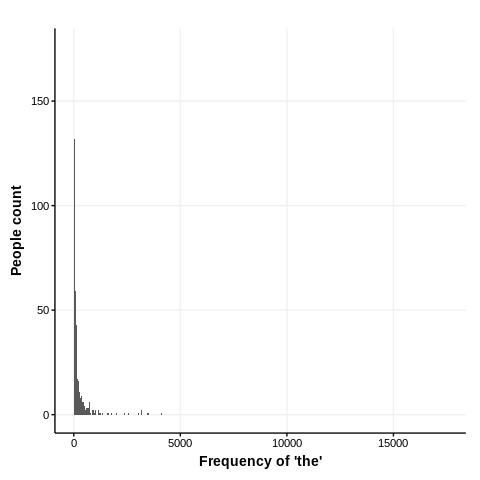

In [ ]:
%%R

ggplot(data = feat_the, aes(x = value)) +
  geom_histogram(bins = 1000) +
  theme_Publication() +
  xlab("Frequency of 'the'") +
  ylab("People count")

Let's put this on a log scale:

In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


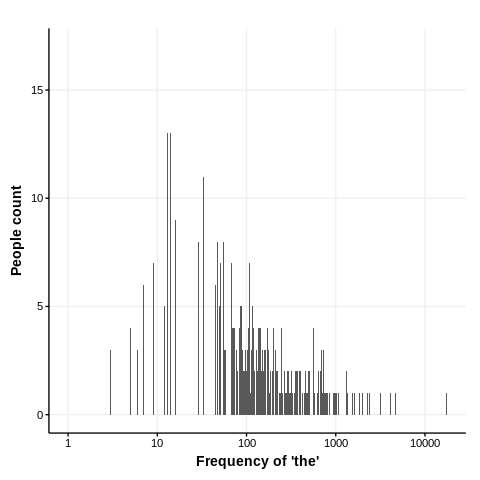

In [ ]:
%%R

qplot(feat_the$value, bins = 1000) +
  theme_Publication() +
  xlab("Frequency of 'the'") +
  ylab("People count") +
  scale_x_log10()

Now, descriptives for the counts:

In [ ]:
%%R

describe(feat_the$value)

   vars   n   mean     sd median trimmed   mad min   max range  skew kurtosis
X1    1 998 265.77 826.86     74  120.99 78.58   1 17513 17512 12.31   214.69
      se
X1 26.17


For the relative count, see the answer below.

#### 2) Please compute the average relative frequency of "they"

the dumb way: across all users who have said they
the right way: across all users
Is the relative percentage difference between these numbers bigger or larger than that for love and backpack? Why is that?


##### *Dumb way*
The dumb way is to get the rows with "they" from the feature tables, and then averaging the `group_norm`.



In [ ]:
%%R

feat_they <- dbGetQuery(db_con, "SELECT * FROM feat$1gram$msgs$user_id WHERE feat = 'they'")
mean(feat_they$group_norm)

[1] 0.003274295


##### *Right way*
To solve this the right way, let's first extract rows where `feat` is "they". To make sure that they are imported right, we'll describe the feature table using `checkDf2` from our custom R package.



In [ ]:
%%R

feat_they <- dbGetQuery(db_con, "SELECT * FROM feat$1gram$msgs$user_id WHERE feat = 'they'")
checkDf2(feat_they)

Now, the steps we all were waiting for... We'll change our feature table from the long format to wide format using `importFeat` from our R script file.

In [ ]:
%%R

feat_they <- importFeat(feat_they)
checkDf2(feat_they)


Note that it only has 887 rows! So we still are missing 113 `group_id`s who did not show up because the table is sparse.

Let's also import `outcomes`



In [ ]:
%%R

outcomes <- dbGetQuery(db_con, "SELECT * FROM outcomes")


To get statistics across all 1000 users, we'll do a join with `outcomes` retaining all the user_ids in it - a right join in this case. Note the `all.y = TRUE`.



In [ ]:
%%R

FO <- merge(feat_they, outcomes, by.x = 'group_id', by.y = 'user_id', all.y = TRUE)
checkDf2(FO)


Note the NAs among the "they" column. Let's replace those with 0s.



In [ ]:
%%R

# now let's add 0 they frequncies that are NA
FO[is.na(FO$they), "they"] <- 0
checkDf2(FO)

           names NAs numeric   min                max zeroes nonNA unique
1       group_id   0       1 28451            4325889      0  1000   1000
2           they   0       1     0 0.0198343504795118    113  1000    862
3         gender   0       1     0                  1    502  1000      2
4            age   0       1    13                 48      0  1000     26
5           occu   0       0                                             
6           sign   0       0                                             
7      is_indunk   0       1     0                  1    642  1000      2
8     is_student   0       0                                             
9   is_education   0       0                                             
10 is_technology   0       0                                             
11     wordcount   0       1   419             365311      0  1000    917



NOW we have a complete table!

Now that we have merged it, it's an easy summary using `tidyverse`.



In [ ]:
%%R

FO %>%
  summarise(mean(they))

  mean(they)
1  0.0029043


#### 3) Averaging the correct way, how often was "of", as an average relative frequency across users mentioned by women? and by men?

As in the above question, get the rows from feature table that have `of`.



In [ ]:
%%R

feat_of <- dbGetQuery(db_con, "SELECT * FROM feat$1gram$msgs$user_id WHERE feat = 'of'")
checkDf2(feat_of)


And convert the feature table into wide format.



In [ ]:
%%R

feat_of <- importFeat(feat_of)
checkDf2(feat_of)

     names NAs numeric                 min                max zeroes nonNA
1 group_id   0       1               28451            4325889      0   999
2       of   0       1 0.00067598017124831 0.0407673860911271      0   999
  unique
1    999
2    974


Let's also read the `outcomes` table.



In [ ]:
%%R

outcomes <- dbGetQuery(db_con, "SELECT * FROM outcomes")


Similar to above question, let's merge the two tables to include all users.



In [ ]:
%%R

FO <- merge(feat_of, outcomes, by.x = 'group_id', by.y = 'user_id', all.y = TRUE)
checkDf2(FO)

Note in the output that there was one NA for of, so let's set it to 0.

In [ ]:
%%R

#setting NA to 0
FO[is.na(FO$of), "of"] <- 0
checkDf2(FO)

           names NAs numeric   min                max zeroes nonNA unique
1       group_id   0       1 28451            4325889      0  1000   1000
2             of   0       1     0 0.0407673860911271      1  1000    975
3         gender   0       1     0                  1    502  1000      2
4            age   0       1    13                 48      0  1000     26
5           occu   0       0                                             
6           sign   0       0                                             
7      is_indunk   0       1     0                  1    642  1000      2
8     is_student   0       0                                             
9   is_education   0       0                                             
10 is_technology   0       0                                             
11     wordcount   0       1   419             365311      0  1000    917


With vanilla R, we can get the results using

In [ ]:
%%R
mean(FO[FO$gender == 1,"of"])

[1] 0.01287938


In [ ]:
%%R
mean(FO[FO$gender == 0,"of"])

[1] 0.01548485



But it's much more elegant with `tidyverse`.



In [ ]:
%%R

FO %>%
  group_by(gender) %>%
  summarize(avg = mean(of)) %>%
  data.frame()

  gender        avg
1      0 0.01548485
2      1 0.01287938


Or even more by using the line-magic!

#### Questions 4-5

4. What are top 100 most frequent words across all users?
5. Do women use more distinct tokens (types) than men?

Since both the above questions involve `COUNT()` over large tables, it's better to solve them over SQL than bring them into R.


#### Questions 7-8

7. Averaging the dumb way (across those who use the word) in terms of relative frequency, which zodiac sign uses the f-word the most?
8. Averaging the dumb way (across those who use the feature) in terms of relative frequency, which age uses "I" the most? Are you surprised?

Both the questions are similar, and also involve joining large tables. We'll solve only 8 below. Make sure to look for the lower case feature.

We'll merge the `outcomes` and `msgs` tables below!!



In [ ]:
%%R

feat_i <- dbGetQuery(db_con, "SELECT * FROM feat$1gram$msgs$user_id where feat = 'i'")
feat_i <- importFeat(feat_i)
checkDf2(feat_i)

Definitely not a good idea to do a `importFeat()` over the entire feature table. Guess we'll make do with long format this time.



In [ ]:
%%R

outcomes <- dbGetQuery(db_con, "SELECT * FROM outcomes")
FO <- merge(feat_i, outcomes, by.x = 'group_id', by.y = 'user_id')
checkDf2(FO)

Then follow it with filter on the feature "I", followed with a group by over the age, and summarize.

In [ ]:
%%R

FO %>%
  group_by(age) %>%
  summarise(avg_i = mean(i)) %>%
  arrange(desc(avg_i)) %>%
  data.frame()

   age      avg_i
1   39 0.03860288
2   17 0.03519592
3   15 0.03447915
4   16 0.03417368
5   34 0.03294492
6   23 0.03223567
7   14 0.03199712
8   13 0.03122030
9   47 0.03042196
10  46 0.02938090
11  33 0.02932894
12  24 0.02901421
13  27 0.02890808
14  26 0.02871526
15  25 0.02806317
16  35 0.02762723
17  38 0.02678365
18  42 0.02482612
19  40 0.02396859
20  41 0.02315208
21  45 0.02305329
22  36 0.02288434
23  44 0.02225048
24  37 0.01947021
25  43 0.01930372
26  48 0.01640089



It's very easy to mod the above code so that you get "the right" average for I for the age groups -- can you do that here? It's just an attention check based on the code segments we just went thruogh.


#### 9. Double points: Which star sign has the biggest vocabulary, on average?
Let's do this one properly. First, we need the vocab size for every person. Then, we need to average them by star sign. Also include in your output how many people we have per star sign, how many tokens they have on average, and the percentage of women in that group. Looking at your output, what's the best explanation for the apparent vocabulary size of the star signs? Is it their zodiac sign, or something else?

We would get the person level table into R (with counts and distincts -- that's best done in SQL), and then do the star sign aggregation here. See HW2 solutions.


### HW3 Questions


#### 1) Now please extract all of LIWC2015 for the users of the blog sample (extract = add the dictionary feature table).

To extract the LIWC2015 features, use this DLATK command!


In [ ]:
database = "dla_tutorial"
msgs_table = 'msgs'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --add_lex_table -l LIWC2015

#### 2) Which gender has a higher relative frequency of MONEY words? (female = 1). Please do it the right way

Let's get the required feature table and the `blog_outcomes` first.



In [ ]:
%%R

feat_liwc <- dbGetQuery(db_con, "SELECT * FROM feat$cat_LIWC2015$msgs$user_id$1gra")
checkDf2(feat_liwc)

outcomes <- dbGetQuery(db_con, "SELECT * FROM outcomes")
checkDf2(outcomes)

           names NAs numeric   min     max zeroes nonNA unique
1        user_id   0       1 28451 4325889      0  1000   1000
2         gender   0       1     0       1    502  1000      2
3            age   0       1    13      48      0  1000     26
4           occu   0       0                                  
5           sign   0       0                                  
6      is_indunk   0       1     0       1    642  1000      2
7     is_student   0       0                                  
8   is_education   0       0                                  
9  is_technology   0       0                                  
10     wordcount   0       1   419  365311      0  1000    917



To solve this, we convert the feature table in long format to wide (the right way) and then merge it with the outcomes.



In [ ]:
%%R

feat_liwc <- importFeat(feat_liwc)
checkDf2(feat_liwc)

FO <- merge(feat_liwc, outcomes, by.x = "group_id", by.y = "user_id")
checkDf2(FO)

Note that you don't need to specify `all.y = TRUE` anymore, because feat table has an intercept feature, and so you get all group_id's. The importFeat() function already sets 0's for all feats for all group_id that were in the table.


Now, we just have to get the averages per group from the merged table.



In [ ]:
%%R

mean(FO[FO$gender == 1,"MONEY"])

[1] 0.004136605


In [ ]:
%%R

mean(FO[FO$gender == 0,"MONEY"])

[1] 0.005389312


We can do the same using `tidyverse` as shown below.



In [ ]:
%%R

FO %>%
  group_by(gender) %>%
  summarize(mean(MONEY)) %>%
  data.frame()

  gender mean.MONEY.
1      0 0.005389312
2      1 0.004136605


#### 3) Get the 10 occupations that have the highest proportion of POSEMO to NEGEMO langauge

From the homework we already know that we can do this in 2 ways. Let's stick to the one where we extract occupation level features and then calculate the proportion. So, the first thing is to extract occupation level features. (`--correl occu`)



Step 1 of this is to create a merged messages and outcomes (specifically occupations) table.

In [ ]:
%%sql

DROP TABLE IF EXISTS merged_msgs_with_occu;

CREATE TABLE merged_msgs_with_occu AS SELECT msgs.*, outcomes.occu
                                      FROM msgs, outcomes
                                      WHERE msgs.user_id = outcomes.user_id;

CREATE INDEX idx_merged_msgs_with_occu_occu ON merged_msgs_with_occu (occu);

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

++
||
++
++

Now extract occupation-level features!

In [ ]:
database = "dla_tutorial"
msgs_table = 'merged_msgs_with_occu'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field occu \
    --add_lex_table -l mini_LIWC2015

Now that we have done that, let's import the table and then convert it into wide format as in above question.

In [ ]:
%%R

feat_occu_liwc <- dbGetQuery(
  db_con,
  "SELECT * FROM feat$cat_mini_LIWC2015$merged_msgs_with_occu$occu$1gra")
checkDf2(feat_occu_liwc)

feat_occu_liwc <- importFeat(feat_occu_liwc)
checkDf2(feat_occu_liwc)


Since the table is in the wide format, it's easy to get the proportion using the command below.



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


In addition: Warning message:
`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 


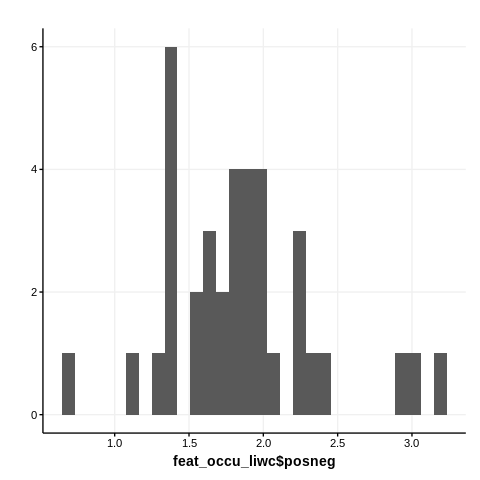

In [ ]:
%%R

feat_occu_liwc$posneg <- feat_occu_liwc$POSEMO / feat_occu_liwc$NEGEMO
qplot(feat_occu_liwc$posneg) +
  theme_Publication()

Finally, let's get the top ones.



In [ ]:
%R feat_occu_liwc %>% arrange(desc(posneg))

SO MUCH EASIER THAN SQL!!

#### 4) Please pull out 10 random blogs that contain MONEY words.

That's for SQL! Let's not pull the message table into R.x

#### 8) Which are the 10 most frequent words within the LIWC BIO dictionary? Which fraction of total dictionary occurrences do the sum of the occurrences of these 10 words account for?

To solve this, we'll get the word counts from SQL and also the BIO dictionary. Let's get those first.

In [ ]:
%%R

wc <- dbGetQuery(db_con, "SELECT feat, SUM(value) AS count FROM feat$1gram$msgs$user_id GROUP BY feat")
checkDf2(wc)

  names NAs numeric min    max zeroes  nonNA unique
1  feat   0       0                                
2 count   0       1   1 365156      0 137687   1459


In [ ]:
%%R

bio <- dbGetQuery(db_con, "SELECT * FROM dlatk_lexica.LIWC2015 WHERE category = 'BIO'")

Then we merge it with the `BIO` dictionary to get the top 10 words (using savvy piping `%>% head() %>% data.frame()` ).

In [ ]:
%%R

BW <- merge(bio, wc, by.x = 'term', by.y = 'feat')
BW %>%
  arrange(desc(count)) %>%
  head(10) %>% data.frame()

    term   id category weight count
1   love 5491      BIO      1  9346
2   life 5480      BIO      1  8732
3   head 5404      BIO      1  2755
4   live 5485      BIO      1  2591
5  heart 5417      BIO      1  2502
6  sleep 5686      BIO      1  2205
7   face 5334      BIO      1  2015
8  tired 5769      BIO      1  1858
9   hand 5400      BIO      1  1741
10  fuck 5369      BIO      1  1690


To get relative frequencies:



In [ ]:
%%R

sum_of_bio_words <- sum(BW$count)
BW$count_normalized <- BW$count / sum_of_bio_words

BW %>%
  arrange(desc(count_normalized)) %>%
  head(10) %>%
  data.frame()

    term   id category weight count count_normalized
1   love 5491      BIO      1  9346       0.11307925
2   life 5480      BIO      1  8732       0.10565033
3   head 5404      BIO      1  2755       0.03333333
4   live 5485      BIO      1  2591       0.03134906
5  heart 5417      BIO      1  2502       0.03027223
6  sleep 5686      BIO      1  2205       0.02667877
7   face 5334      BIO      1  2015       0.02437992
8  tired 5769      BIO      1  1858       0.02248034
9   hand 5400      BIO      1  1741       0.02106473
10  fuck 5369      BIO      1  1690       0.02044767


And then just sum the top 10 normalized counts in R. (leaving as Exercise)

#### 10) Which age group generally uses the most POSEMO? (using simple averages of group_norms)?

In the first step, read the LIWC features and `blog_outcomes`.



In [ ]:
%%R

feat_liwc <- dbGetQuery(db_con, "SELECT * FROM feat$cat_LIWC2015$msgs$user_id$1gra")
checkDf2(feat_liwc)

       names NAs numeric                  min     max zeroes nonNA unique
1         id   0       1                    1   71393      0 71393  71393
2   group_id   0       1                28451 4325889      0 71393   1000
3       feat   0       0                                                 
4      value   0       1                    1  161281      0 71393   3174
5 group_norm   0       1 4.37982978886483e-05       1      0 71393  54417


Change it to wide format



In [ ]:
%%R

feat_liwc <- importFeat(feat_liwc)
checkDf2(feat_liwc)


Remember the "dummy" `_intercept` feature, well that makes sure here to retain all the users here unlike one-gram tables.

Anyway, let's read the outcomes table.



In [ ]:
%%R

outcomes <- dbGetQuery(db_con, "SELECT * FROM outcomes")
checkDf2(outcomes)

           names NAs numeric   min     max zeroes nonNA unique
1        user_id   0       1 28451 4325889      0  1000   1000
2         gender   0       1     0       1    502  1000      2
3            age   0       1    13      48      0  1000     26
4           occu   0       0                                  
5           sign   0       0                                  
6      is_indunk   0       1     0       1    642  1000      2
7     is_student   0       0                                  
8   is_education   0       0                                  
9  is_technology   0       0                                  
10     wordcount   0       1   419  365311      0  1000    917



This is followed by a merge as usual.



In [ ]:
%%R

FO <- merge(feat_liwc, outcomes, by.x = 'group_id', by.y = 'user_id')
checkDf2(FO)


Later, `tidyverse` does the trick.

This are actually done the right way -- 0's were inserted by importFeat -- so these are the real relative frequencies.

Exercise: can you plot this over age?



In [ ]:
%%R

FO %>%
  group_by(age) %>%
  summarise(mean = mean(POSEMO)) %>%
  arrange(desc(mean)) %>%
  data.frame()

   age       mean
1   16 0.03365538
2   38 0.03364668
3   14 0.03362801
4   15 0.03322201
5   17 0.03275249
6   13 0.03270106
7   36 0.03154150
8   45 0.03105807
9   44 0.03018316
10  33 0.02980422
11  23 0.02940412
12  25 0.02919368
13  27 0.02915218
14  24 0.02867853
15  26 0.02838988
16  40 0.02822496
17  43 0.02808062
18  47 0.02790364
19  39 0.02787737
20  35 0.02786563
21  48 0.02745807
22  37 0.02731702
23  34 0.02707156
24  42 0.02691967
25  46 0.02497994
26  41 0.02309515


Yay! 😃

## ‼️ **Save your database and/or output files** ‼️

Let's save all this work into your Google Drive `sqlite_databases` folder!

In [ ]:
database = 'dla_tutorial'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

Mounted at /content/drive
✅ Database 'dla_tutorial.db' has been copied to your Google Drive.
